Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

# Schedule Azure Machine Learning Pipelines

In this tutorial, you will learn how to schedule Azure Machine Learning pipelines. The example does a simple data-preparation task every minute. Raw data are read from a CSV file, normalized, and output to another CSV file for downstream processing.

## Domain

The fake domain of this tutorial relates to colors. We are pretending that our input data consists of a set of "votes" for a color that we need to preprocess for our downstream ML system. The following cells reflect the contents of the **pipeline_src/color.py** file.

In [1]:
from enum import Enum, unique
import numpy as np

In [2]:
  @unique
class Color(Enum) : 
    Red = 0 
    Orange = 1 
    Yellow = 2
    Green = 3
    Blue = 4
    Indigo = 5
    Violet = 6
    
    @classmethod
    def randn_color(cls) : 
        v = np.random.randn()
        c = next((c for c in Color if v < (0.65 * (float(c.value) - 2.5))), Color.Violet)
        return c

Verify that our method `randn_color()` produces a normally-distributed shape:

In [3]:
cs = list(Color.randn_color().value for _ in range(1000))

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

(array([ 61., 106., 201., 287., 185., 116.,  44.]),
 array([0.        , 0.85714286, 1.71428571, 2.57142857, 3.42857143,
        4.28571429, 5.14285714, 6.        ]),
 <a list of 7 Patch objects>)

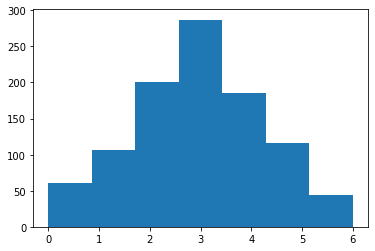

In [5]:
plt.hist(cs,len(Color))

## What's going on in the training script...

This section reflect the functions in the **pipeline_src/preprocessing.py** file. 

To simulate some out-of-process data collection, the file **preprocessing.py** generates fake data and writes it to a file **unprocessed_data.csv**. 

Then, **preprocessing.py** reads that file, and "prepares the data for ML." In this case, it does some data transformation and normalizes the results. It writes the results to **processed_data.csv**. 

One scenario might be retraining or inferencing periodically. Another scenario, if data preparation was a very expensive step, would be to run a preprocessing pipeline on one schedule and retraining on another, slower, schedule. Azure ML Pipelines give you the flexibility to tackle either of those scenarios.

In [6]:
from datetime import datetime,timedelta

In [7]:
def generate_fake_data(minutes, mu, sigma) :
    end_time = datetime.now()
    start_time = end_time - timedelta(minutes=minutes)
    # Generate a random amount of data
    amount_of_fake_data = minutes * int(mu + sigma * np.random.randn())
    # Generate at least 1 element
    amount_of_fake_data = 1 if amount_of_fake_data < 1 else amount_of_fake_data
    arrival_times = np.arange(start_time, end_time, timedelta(minutes = minutes / amount_of_fake_data)).astype(datetime)
    color_votes = list(Color.randn_color().name for _ in range(amount_of_fake_data))
    time_and_vote = zip(arrival_times, color_votes)
    return time_and_vote

`generate_fake_data()` creates a sequence of tuples. Each tuple has an arrival time and a "vote" for a particular color. The arrival times are arrive over the past `minutes`:

In [8]:
list(generate_fake_data(1, 5, 1))

[(datetime.datetime(2019, 10, 2, 9, 5, 21, 558062), 'Blue'),
 (datetime.datetime(2019, 10, 2, 9, 5, 41, 558062), 'Blue'),
 (datetime.datetime(2019, 10, 2, 9, 6, 1, 558062), 'Yellow')]

In [9]:
import os
import csv

In [10]:
def fake_data(storage_dir) : 
    input_data_file = 'unprocessed_data.csv'
    input_path = os.path.join(storage_dir, input_data_file)
    # If first time, generate a bit more data 
    minutes_back = 1 if os.path.exists(input_path) else 10 
    data = generate_fake_data(minutes_back, 100, 50)
    with open(input_path, mode='w+') as f : 
        writer = csv.writer(f)
        writer.writerows(data)


In [11]:
fake_data('.')

`fake_data()` creates or appends to the file `unprocessed_data.csv` in `storage_dir`, adding the results of some amount of `generate_fake_data()`. This `unprocessed_data.csv` file stands in for the output of some external datasource (Web site, field data, etc.)

```
2019-09-30 14:10:00.673782,Green
2019-09-30 14:10:01.805857,Yellow
2019-09-30 14:10:02.937932,Indigo
```

### Data Processing

The goal of this section is to read the unprocessed data and do some kind of "preparation" for ML. In this contrived situation, the steps are:

* Read the raw data
* Transform the human-readable record times into UNIX timestamp values 
* Transform the human-readable color "vote" into a numeric value
* Normalize both the timestamps and votes 
* Write the processed data 



In [12]:
def read_raw_data(storage_dir) : 
    input_data_file = 'unprocessed_data.csv'
    input_path = os.path.join(storage_dir, input_data_file)
    if os.path.exists(input_path) : 
        with open(input_path, mode='r') as f : 
            reader = csv.reader(f)
            return list(reader)
    else :
        # If file doesn't exist, return empty list 
        return []

In [13]:
raw_data = read_raw_data('.')[0:5]
raw_data

[['2019-10-02 09:05:21.576713', 'Orange'],
 ['2019-10-02 09:05:23.290999', 'Yellow'],
 ['2019-10-02 09:05:25.005285', 'Red'],
 ['2019-10-02 09:05:26.719571', 'Green'],
 ['2019-10-02 09:05:28.433857', 'Orange']]

In [14]:
import dateutil

In [15]:
from sklearn.preprocessing import normalize

In [16]:
# Please note: this is just a silly example of converting and normalizing, aka "preprocessing stuff"     
def process_raw_data(raw_data) : 
    def convert(d) :
        for datum in d : 
            dt = dateutil.parser.parse(datum[0])
            ts = int(dt.timestamp())
            c = Color[datum[1]].value
            yield (ts, c)
    processed_data = list(convert(raw_data))
    normalized_data = normalize(processed_data, axis = 0)
    return normalized_data

process_raw_data(raw_data)

array([[0.44721359, 0.25819889],
       [0.4472136 , 0.51639778],
       [0.4472136 , 0.        ],
       [0.4472136 , 0.77459667],
       [0.4472136 , 0.25819889]])

In [17]:
def write_processed_data(storage_dir, processed_data) : 
    output_data_file = 'processed_data.csv'
    output_path = os.path.join(storage_dir, output_data_file)

    # Note: Clobbers existing processed data -- fine in this example
    with open(output_path, mode='w') as f : 
        writer = csv.writer(f)
        writer.writerows(processed_data)

In [18]:
def main() : 
    storage_dir = '.'
    # Write some fake data to 'unprocessed_data.csv' -- normally data would be written via some external process
    fake_data(storage_dir)

    print("Beginning periodic data processing...")
    raw_data = read_raw_data(storage_dir)
    processed_data = process_raw_data(raw_data)
    write_processed_data(storage_dir, processed_data)
    print(f"Wrote {len(processed_data)} records")
    print("...Periodic data processing ended.")

In [19]:
main()

Beginning periodic data processing...
Wrote 39 records
...Periodic data processing ended.


## Creating and scheduling a pipeline



In [20]:
import azureml.core
azureml.core.VERSION

'1.0.65'

In [21]:
from azureml.core.authentication import InteractiveLoginAuthentication
#Larry's tenant
interactive_auth = InteractiveLoginAuthentication(tenant_id="72f988bf-86f1-41af-91ab-2d7cd011db47")

In [22]:
from azureml.core import Workspace

subscription_id = '65a1016d-0f67-45d2-b838-b8f373d6d52e'
resource_group  = 'laobri_0925_ml'
workspace_name  = 'laobri_schedule_pipelines'

ws = Workspace(subscription_id = subscription_id, resource_group = resource_group, workspace_name = workspace_name, auth=interactive_auth)

In [23]:
from azureml.core.runconfig import RunConfiguration
from azureml.core.compute import AmlCompute
list_vms = AmlCompute.supported_vmsizes(workspace=ws)
list_vms

[{'name': 'Standard_DS1_v2',
  'vCPUs': 1,
  'gpus': 0,
  'memoryGB': 3.5,
  'maxResourceVolumeMB': 7168},
 {'name': 'Standard_DS2_v2',
  'vCPUs': 2,
  'gpus': 0,
  'memoryGB': 7.0,
  'maxResourceVolumeMB': 14336},
 {'name': 'Standard_DS3_v2',
  'vCPUs': 4,
  'gpus': 0,
  'memoryGB': 14.0,
  'maxResourceVolumeMB': 28672},
 {'name': 'Standard_DS4_v2',
  'vCPUs': 8,
  'gpus': 0,
  'memoryGB': 28.0,
  'maxResourceVolumeMB': 57344},
 {'name': 'Standard_DS5_v2',
  'vCPUs': 16,
  'gpus': 0,
  'memoryGB': 56.0,
  'maxResourceVolumeMB': 114688},
 {'name': 'Standard_DS11_v2',
  'vCPUs': 2,
  'gpus': 0,
  'memoryGB': 14.0,
  'maxResourceVolumeMB': 28672},
 {'name': 'Standard_DS12_v2',
  'vCPUs': 4,
  'gpus': 0,
  'memoryGB': 28.0,
  'maxResourceVolumeMB': 57344},
 {'name': 'Standard_DS13_v2',
  'vCPUs': 8,
  'gpus': 0,
  'memoryGB': 56.0,
  'maxResourceVolumeMB': 114688},
 {'name': 'Standard_DS14_v2',
  'vCPUs': 16,
  'gpus': 0,
  'memoryGB': 112.0,
  'maxResourceVolumeMB': 229376},
 {'name': 'S

In [24]:
from azureml.core import Datastore, Experiment
from azureml.data.data_reference import DataReference

#blob_store = Datastore(ws, "workspaceblobstore")
compute_target = ws.compute_targets["cpu-compute"]


In [25]:
compute_config = RunConfiguration()
compute_config.target = "amlcompute"
compute_config.amlcompute.vm_size = "STANDARD_D1_V2"

In [26]:
from azureml.core.conda_dependencies import CondaDependencies

dependencies = CondaDependencies()
dependencies.add_pip_package("scikit-learn")
compute_config.environment.python.conda_dependencies = dependencies

TODO: Might be able to kill the cell below. I think `compute_config` works with my existing pipeline afterwards

{>>
from azureml.core.experiment import Experiment
from azureml.core import ScriptRunConfig

script_run_config = ScriptRunConfig(source_directory='/Users/lobrien 1/Documents/src/AzureDocs/MLOps/examples/pipeline-scheduling/preprocessing_src/', script="train.py", run_config=compute_config)
experiment = Experiment(workspace=ws, name="compute_target_test")
run = experiment.submit(config=script_run_config)
run.wait_for_completion(show_output=True)
>>}

In [27]:
experiment = Experiment(ws, 'MyExperiment') 

In [28]:
from azureml.pipeline.steps import PythonScriptStep
from azureml.pipeline.core import Pipeline

In [29]:
steps = [ PythonScriptStep(
    script_name="train.py",
    arguments=[],
    inputs=[],
    outputs=[],
    compute_target=compute_target,
    runconfig = compute_config,
    source_directory="/Users/lobrien 1/Documents/src/AzureDocs/MLOps/examples/pipeline-scheduling/preprocessing_src/"
) ]

pipeline = Pipeline(workspace=ws, steps=steps)

pipeline_run = experiment.submit(pipeline)
pipeline_run.wait_for_completion()

'gpu_support' is no longer necessary; AzureML now automatically detects and uses nvidia docker extension when it is available. It will be removed in a future release.


Created step train.py [e4715bb7][5c925bd9-a46f-43d3-a2bb-033480842349], (This step is eligible to reuse a previous run's output)
Submitted PipelineRun 196546a7-0372-48c0-90b9-f4c44433aa37
Link to Azure Portal: https://mlworkspace.azure.ai/portal/subscriptions/65a1016d-0f67-45d2-b838-b8f373d6d52e/resourceGroups/laobri_0925_ml/providers/Microsoft.MachineLearningServices/workspaces/laobri_schedule_pipelines/experiments/MyExperiment/runs/196546a7-0372-48c0-90b9-f4c44433aa37
PipelineRunId: 196546a7-0372-48c0-90b9-f4c44433aa37
Link to Portal: https://mlworkspace.azure.ai/portal/subscriptions/65a1016d-0f67-45d2-b838-b8f373d6d52e/resourceGroups/laobri_0925_ml/providers/Microsoft.MachineLearningServices/workspaces/laobri_schedule_pipelines/experiments/MyExperiment/runs/196546a7-0372-48c0-90b9-f4c44433aa37
PipelineRun Status: Running


StepRunId: 8a955c52-d28c-492c-87b3-5a825904d133
Link to Portal: https://mlworkspace.azure.ai/portal/subscriptions/65a1016d-0f67-45d2-b838-b8f373d6d52e/resourceGro

'Finished'

In [30]:
published_pipeline = pipeline_run.publish_pipeline("My first scheduled pipeline",f"my description {str(datetime.now())}", "0.0.4")

In [31]:
published_pipeline

Name,Id,Status,Endpoint
My first scheduled pipeline,071d11e6-ad62-43c6-a8b5-7f4dccc7ed0a,Active,REST Endpoint


In [32]:
published_pipeline.id

'071d11e6-ad62-43c6-a8b5-7f4dccc7ed0a'

In [33]:
from azureml.pipeline.core import Schedule, ScheduleRecurrence

recurrence = ScheduleRecurrence(frequency="Hour", interval=1)
schedule = Schedule.create(ws, name="TestSchedule", pipeline_id=published_pipeline.id,
                          experiment_name="MyExperiment", recurrence=recurrence)

In [34]:
## Cleaning up

In [35]:
print(f"To retrieve the pipeline later, use it's `id`: {published_pipeline.id}")

To retrieve the pipeline later, use it's `id`: 071d11e6-ad62-43c6-a8b5-7f4dccc7ed0a


Or, you can get the pipelines running in your workspace:

In [39]:
ps = Schedule.list(ws)
ps

[Pipeline(Name: TestSchedule,
 Id: 118d927d-efd7-4b22-a97d-8a1d7e8030c2,
 Status: Active,
 Pipeline Id: 071d11e6-ad62-43c6-a8b5-7f4dccc7ed0a,
 Recurrence Details: Runs every Hour), Pipeline(Name: TestSchedule,
 Id: aa69f03b-26ec-4bc3-a53e-9a33e0560ddc,
 Status: Active,
 Pipeline Id: 304dd02a-6d28-4338-ac53-5b6111705f42,
 Recurrence Details: Runs every Hour)]

In [37]:
from azureml.pipeline.core import PublishedPipeline

In [38]:
do_cleanup = False
if do_cleanup : 
    p = PublishedPipeline.get(ws, id="?")
    p.disable()